# News Popularity across Platforms

### Source: UCI Machine Learning Repository
   ### Weblink: [UCI Website](https://archive.ics.uci.edu/ml/datasets/Parkinson+Disease+Spiral+Drawings+Using+Digitized+Graphics+Tablet#)
    Nuno Moniz 
    LIAAD - INESC Tec; Sciences College, University of Porto 
    Email: nmmoniz@inesctec.pt 

    Luis Torgo 
    LIAAD - INESC Tec; Sciences College, University of Porto 
    Email: ltorgo@dcc.fc.up.pt
### Relevant Papers:
   #### Nuno Moniz and Luis Torgo (2018) [Multi-Source Social Feedback of Online News Feeds](https://arxiv.org/abs/1801.07055)

In [1]:
from viralnews.get_news import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-paper')

import seaborn as sb
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd

from itertools import chain
from collections import Counter

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/'

In [3]:
file = "https://archive.ics.uci.edu/ml/machine-learning-databases/00432/Data/Facebook_Economy.csv"

In [4]:
fb_economy = pd.read_csv(file,index_col='IDLink')

In [5]:
fb_economy.tail()

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,...,TS135,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143,TS144
IDLink,,,,,,,,,,,,,,,,,,,,,
58440,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
58441,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
58444,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
58446,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,2,2,2,2,2,2,2,2,2,2
58447,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [6]:
top_10 = fb_economy.TS144.nlargest(10).index

**Investigating the lifespan of the ten most popular stories by TS144**

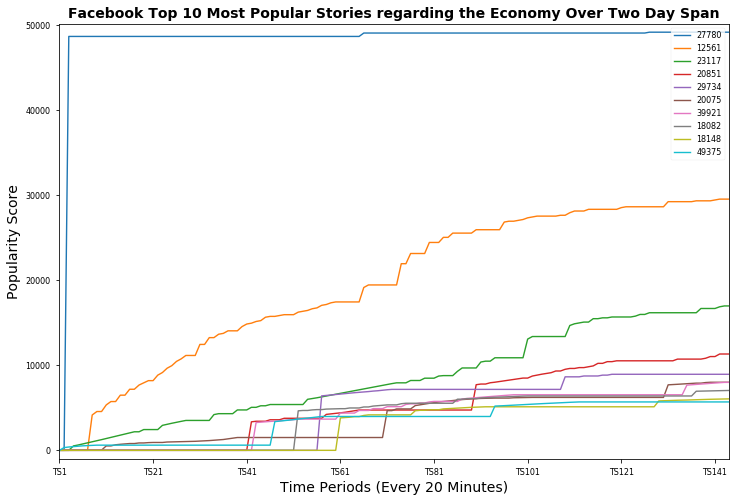

In [7]:
fb_economy.loc[top_10].T.plot(figsize=(12,8))
plt.legend(loc='upper right')
plt.title('Facebook Top 10 Most Popular Stories regarding the Economy Over Two Day Span',fontsize=14,fontweight='bold')
plt.xlabel('Time Periods (Every 20 Minutes)',fontsize=14)
plt.ylabel('Popularity Score',fontsize=14)
plt.margins(0.02)
plt.show()

**Using the chain method to collect the periodic top ten stories and unpack the list of lists into a single list of dicts**

In [8]:
top_10_periodically = list(chain.from_iterable([list(fb_economy[k].nlargest(10).index) for k in list(fb_economy.columns)]))

In [9]:
top_10_periodically[:10]

[47982, 46935, 45397, 2229, 7389, 43233, 43985, 48003, 51600, 2279]

**Converting dicts into tuples to make it easier for DataFrame construction using .from_records(data) method**

In [10]:
count_top_10_appearances = [(k, v) for k, v in dict(Counter(top_10_periodically)).items()]

In [11]:
count_top_10_appearances[:10]

[(47982, 25),
 (46935, 12),
 (45397, 5),
 (2229, 2),
 (7389, 2),
 (43233, 1),
 (43985, 1),
 (48003, 1),
 (51600, 1),
 (2279, 1)]

In [12]:
trending_df = pd.DataFrame.from_records(count_top_10_appearances,columns=['ID','Count']).set_index('ID')

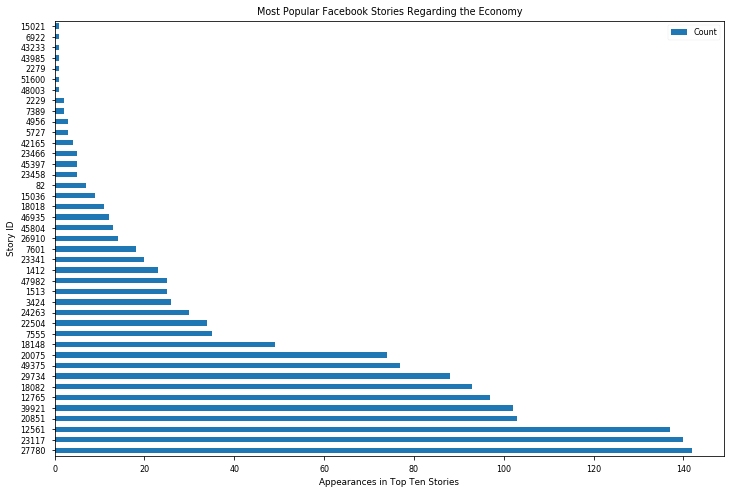

In [13]:
fig = trending_df.sort_values(by='Count',ascending=False).plot(kind='barh',figsize=(12,8))
plt.title('Most Popular Facebook Stories Regarding the Economy')
plt.ylabel('Story ID')
plt.xlabel('Appearances in Top Ten Stories')
plt.show()

In [14]:
fb_economy.loc[27780].max()

49211

### Creating Delayed Objects from .csv files to speed things up

In [15]:
url_list = url_find()

In [16]:
url_list

['Facebook_Economy',
 'Facebook_Microsoft',
 'Facebook_Obama',
 'Facebook_Palestine',
 'GooglePlus_Economy',
 'GooglePlus_Microsoft',
 'GooglePlus_Obama',
 'GooglePlus_Palestine',
 'LinkedIn_Economy',
 'LinkedIn_Microsoft',
 'LinkedIn_Obama',
 'LinkedIn_Palestine']

In [17]:
delayed = (dask.delayed(df_read)(u) for u in url_list)

In [18]:
delayed_df = dd.from_delayed(delayed)
delayed_df = delayed_df.persist()

In [19]:
platform_group = delayed_df.drop(['Platform','Topic'],axis=1).groupby('Platform_Topic')

In [20]:
platform_group.mean().head()

,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,TS10,...,TS135,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143,TS144
Platform_Topic,,,,,,,,,,,,,,,,,,,,,
Facebook_Economy,-0.420710,0.019814,2.061080,2.586240,2.994988,3.285251,3.813085,4.345295,4.701751,5.244219,...,44.256750,44.341687,44.512597,44.618818,44.717221,44.804431,44.888466,45.117482,45.233995,45.335739
Facebook_Microsoft,-0.404349,0.050888,0.482867,1.030813,1.376073,1.671847,2.145972,2.444390,2.673574,3.135772,...,36.434623,36.501160,36.614646,36.713237,36.783606,36.843344,36.950785,36.988614,37.045599,37.081863
Facebook_Obama,2.773903,4.434833,6.643272,11.199371,13.373422,15.518157,19.446863,22.260448,24.857264,29.556061,...,287.680474,288.310642,288.945919,289.585304,290.350694,291.055673,294.480955,296.397594,298.233056,299.485212
Facebook_Palestine,-0.177442,0.148432,0.516977,2.323663,2.673735,3.123715,3.651359,4.105373,4.566671,5.092754,...,53.027579,53.192923,53.334721,53.448419,53.729804,53.875244,54.380513,54.653311,55.038116,55.248471
GooglePlus_Economy,-0.640419,-0.497687,-0.396867,-0.244700,-0.221265,-0.201397,-0.112069,-0.093471,-0.075690,-0.012912,...,1.709214,1.713962,1.719768,1.725211,1.729656,1.733104,1.737065,1.743143,1.746742,1.751247


Text(0.5,0,'Time Periods (Every 20 Minutes)')

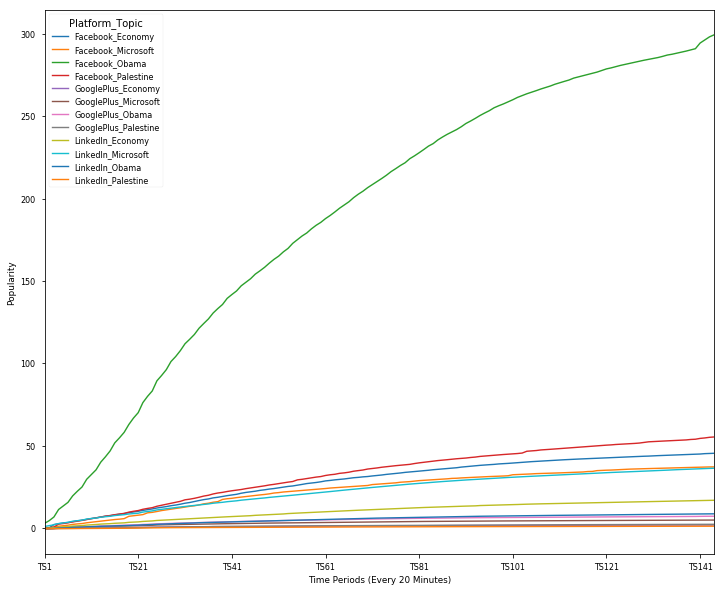

In [21]:
platform_group.mean().compute().T.plot(figsize=(12,10))
plt.ylabel('Popularity')
plt.xlabel('Time Periods (Every 20 Minutes)')

### Unsurprisingly, Facebook articles on Obama drew the most attention.

In [22]:
#for some reason, it is not letting me perform .nlargest() on the SeriesGroupBy object - Dask issue?
#Instead, I am using .apply() with a lambda nlargest function

top_10_by_platform_topic = pd.DataFrame(platform_group.TS144.apply(lambda x: x.nlargest(10)).compute())

C:\Users\mgavin\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


In [23]:
top_10_df = pd.melt(top_10_by_platform_topic.reset_index(),id_vars=['IDLink','Platform_Topic'],value_vars=['TS144'],value_name='Popularity after 2 Days')
top_10_df.drop('variable',axis=1,inplace=True)

In [24]:
top_10_df.set_index('IDLink',drop=True,inplace=True)

In [25]:
top_10_df.index = top_10_df.index.astype('object')

In [26]:
top_10_df.head(20)

,Platform_Topic,Popularity after 2 Days
IDLink,,
72143,Facebook_Obama,40836
76901,Facebook_Obama,32385
72045,Facebook_Obama,30489
62638,Facebook_Obama,24594
67508,Facebook_Obama,22518
65424,Facebook_Obama,19136
67141,Facebook_Obama,17170
90713,Facebook_Obama,16598
94081,Facebook_Obama,15692


In [27]:
top_articles_platform_topic = list(top_10_df.index)

In [28]:
top_articles_platform_topic

[72143,
 76901,
 72045,
 62638,
 67508,
 65424,
 67141,
 90713,
 94081,
 90631,
 23117,
 2070,
 12561,
 7555,
 29734,
 1412,
 12765,
 3582,
 48342,
 20851,
 35873,
 29108,
 23208,
 31272,
 50703,
 38485,
 38474,
 21781,
 31621,
 31777,
 75688,
 66473,
 74359,
 68177,
 79613,
 67508,
 63460,
 94489,
 90631,
 62536,
 41816,
 35329,
 30049,
 35982,
 24651,
 28349,
 54836,
 43985,
 7542,
 13396,
 38485,
 25397,
 35873,
 38319,
 17259,
 56180,
 56122,
 12279,
 23326,
 38474,
 83537,
 86279,
 99044,
 72258,
 76310,
 99163,
 104531,
 78907,
 64210,
 68895,
 101578,
 79184,
 64210,
 103077,
 86158,
 83537,
 66526,
 77265,
 68379,
 68302,
 79184,
 78362,
 103077,
 101578,
 64210,
 72644,
 63938,
 66142,
 81547,
 81168,
 56180,
 56122,
 56155,
 56426,
 56097,
 56124,
 56098,
 56129,
 56254,
 57089,
 27780,
 12561,
 23117,
 20851,
 29734,
 20075,
 39921,
 18082,
 18148,
 49375,
 102171,
 74997,
 104089,
 72807,
 75291,
 99583,
 99042,
 101264,
 67131,
 98542]

In [29]:
top_articles = delayed_df.compute().loc[top_articles_platform_topic]

In [30]:
multiple_appearances = top_articles.loc[top_articles.index.value_counts() >5]

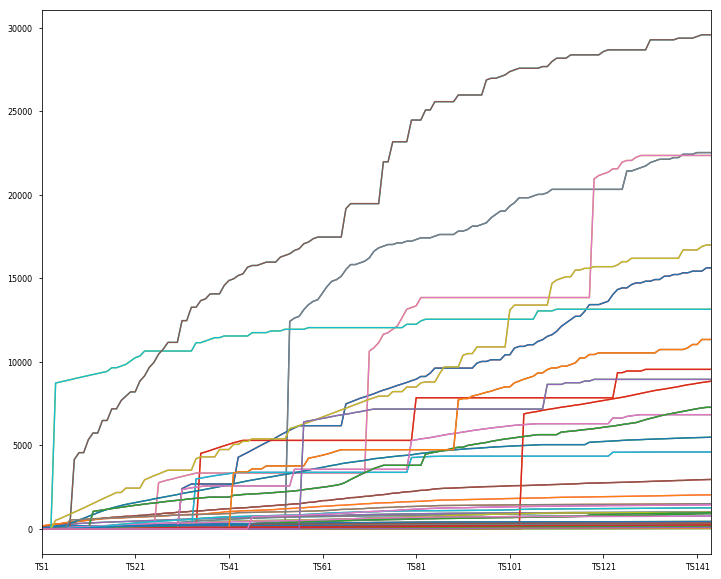

In [31]:
multiple_appearances.drop(['Platform','Topic','Platform_Topic'],axis=1).T.plot(legend=False,figsize=(12,10))

In [32]:
multiple_appearances[multiple_appearances.Platform == 'Facebook'].Topic.value_counts()

Palestine    11
Economy       8
Microsoft     6
Obama         4
Name: Topic, dtype: int64

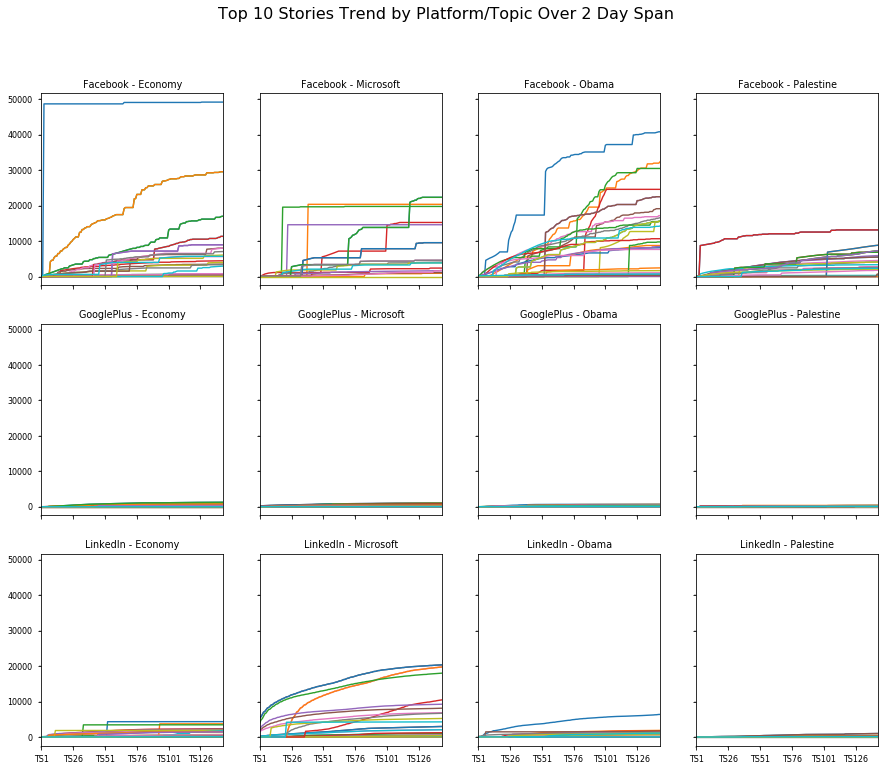

In [33]:
fig, charts = plt.subplots(nrows=3,ncols=4,figsize=(15,12),sharex=True,sharey=True)

for platform_topic, chart in zip(url_list,charts.flatten()):
    df = top_articles.drop(['Platform','Topic'],axis=1)
    platform, topic = platform_topic.split('_')
    df = df[df['Platform_Topic'] == platform_topic]
    df.drop('Platform_Topic',axis=1,inplace=True)
    df.T.plot(ax=chart,legend=False)
    chart.set_title('{} - {}'.format(platform,topic))

plt.suptitle('Top 10 Stories Trend by Platform/Topic Over 2 Day Span',fontsize=16)
plt.figure(figsize=(12,10))
plt.show()

## Observations thus far: ##

    - Facebook appears to have been the preferred platform for sharing new stories
    - GooglePlus was a near non-factor in news popularity metrics
    - LinkedIn cares a lot about Microsoft, due to Microsoft's acquisition of the site (June 2016)

In [34]:
news_final = dd.from_delayed(dask.delayed(pd.read_csv)(url+'News_Final.csv'))
news_final = news_final.persist()

In [35]:
#news_final.IDLink = news_final.IDLink.astype('int64').astype('object')
news_final.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


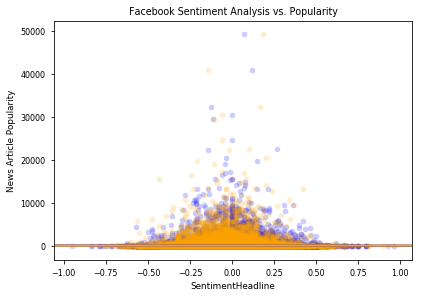

In [36]:
sb.regplot(x='SentimentTitle',y='Facebook',data=news_final.compute(),color='blue',scatter_kws={'alpha':0.2})
sb.regplot(x='SentimentHeadline',y='Facebook',data=news_final.compute(),color='orange',scatter_kws={'alpha':0.2})
plt.ylabel('News Article Popularity')
plt.title('Facebook Sentiment Analysis vs. Popularity')
plt.show()

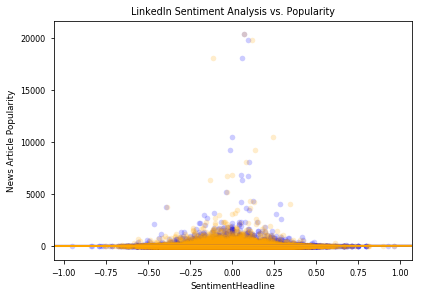

In [37]:
sb.regplot(x='SentimentTitle',y='LinkedIn',data=news_final.compute(),color='blue',scatter_kws={'alpha':0.2})
sb.regplot(x='SentimentHeadline',y='LinkedIn',data=news_final.compute(),color='orange',scatter_kws={'alpha':0.2})
plt.ylabel('News Article Popularity')
plt.title('LinkedIn Sentiment Analysis vs. Popularity')
plt.show()

### Perhaps surprisingly, the most popular articles appear to have a neutral sentiment

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split

In [39]:
news_final = pd.DataFrame(news_final.compute())

In [40]:
facebook_df = news_final[news_final['Facebook'] > 0].drop(['GooglePlus','LinkedIn'],axis=1)

In [41]:
linreg = LinearRegression()
polyfit = PolynomialFeatures()

In [42]:
X_fb = facebook_df[['SentimentTitle','SentimentHeadline']].values
y_fb = facebook_df['Facebook'].values

In [43]:
X_fb_poly = polyfit.fit_transform(X_fb)

In [44]:
r2_scores = cross_val_score(linreg,X_fb_poly,y_fb,cv=5)

In [45]:
r2_scores

array([-0.00475379, -0.00121708, -0.0005998 , -0.01053901, -0.00129032])

### No linear relationship between sentiment score and popularity, which underlying relationship would fit better?

In [46]:
len(facebook_df)

64793

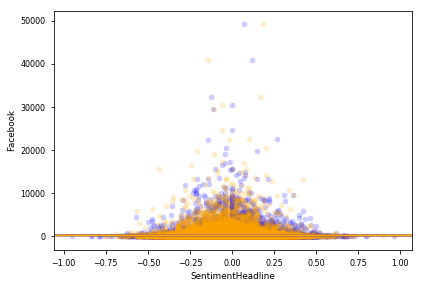

In [47]:
sb.regplot(x='SentimentTitle',y='Facebook',data=facebook_df,color='blue',scatter_kws={'alpha':0.2})
sb.regplot(x='SentimentHeadline',y='Facebook',data=facebook_df,color='orange',scatter_kws={'alpha':0.2})
plt.show()

In [48]:
SentimentMax = []

for index, row in news_final.iterrows():
    max_sentiment = row['SentimentTitle'] if abs(row['SentimentTitle']) > abs(row['SentimentHeadline']) else row['SentimentHeadline']
    SentimentMax.append(max_sentiment)
    
news_final['SentimentMax'] = SentimentMax

In [49]:
for n in ['Facebook','LinkedIn','GooglePlus']:
    news_final[n] = news_final[n].replace(-1,np.median(news_final[n]))
news_final.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,SentimentMax
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,5,0,0,-0.053300
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,5,0,0,0.208333
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,5,0,0,-0.425210
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,5,0,0,0.026064
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,5,0,0,0.141084


In [50]:
news_topic_by_source = pd.get_dummies(news_final,columns=['Topic'],prefix='top',prefix_sep='_')
news_topic_by_source.head()

,IDLink,Title,Headline,Source,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,SentimentMax,top_economy,top_microsoft,top_obama,top_palestine
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,2002-04-02 00:00:00,0.000000,-0.053300,5,0,0,-0.053300,0,0,1,0
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,2008-09-20 00:00:00,0.208333,-0.156386,5,0,0,0.208333,1,0,0,0
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,2012-01-28 00:00:00,-0.425210,0.139754,5,0,0,-0.425210,1,0,0,0
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,2015-03-01 00:06:00,0.000000,0.026064,5,0,0,0.026064,1,0,0,0
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,2015-03-01 00:11:00,0.000000,0.141084,5,0,0,0.141084,1,0,0,0


In [51]:
news_topic_by_source.Source.value_counts()[:500].sum() / len(news_topic_by_source)

0.7283325646993211

In [52]:
prolific_sources = list(news_topic_by_source.Source.value_counts()[:500].index)

In [85]:
prolific_sources[:10]

['Bloomberg',
 'Reuters',
 'ABC News',
 'New York Times',
 'The Guardian',
 'Business Insider',
 'Economic Times',
 'Forbes',
 'Washington Post',
 'CNN']

In [54]:
proportion_topic_by_source = news_topic_by_source.loc[:,['Source',
                                           'top_economy',
                                           'top_microsoft',
                                           'top_obama',
                                           'top_palestine']].groupby('Source').mean()

In [55]:
trimmed_proportion_topic_by_source = proportion_topic_by_source.loc[prolific_sources,:]
trimmed_proportion_topic_by_source.top_economy.nlargest(25)

Source
FXStreet                                   1.000000
ForexLive                                  1.000000
China Daily                                1.000000
RenewEconomy                               1.000000
Hellenic Shipping News Worldwide           1.000000
Scotsman                                   1.000000
This is Money                              1.000000
Nikkei Asian Review                        0.980132
Calgary Herald                             0.977273
Philippine Star                            0.974359
TASS                                       0.964467
BDlive                                     0.963415
Kathimerini                                0.944444
Asia Times                                 0.937500
The Nation Newspaper                       0.930233
South China Morning Post                   0.927273
euronews                                   0.924812
Belfast Telegraph                          0.923913
South China Morning Post (subscription)    0.922330
Bangk

In [56]:
source_topic = news_final.loc[:,['Source','Topic','SentimentMax']].groupby(['Source','Topic']).mean()

## Unstacking grouped object and filtering to just sources in top 500 of stories written

In [57]:
source_topic_sentiment = source_topic.loc[prolific_sources,:].reset_index()
source_topic_sentiment = source_topic_sentiment[source_topic_sentiment.Source != " "]

In [58]:
source_topic_sentiment.head(16)

,Source,Topic,SentimentMax
3,24/7 Wall St.,economy,-0.082386
4,24/7 Wall St.,microsoft,-0.039277
5,AAP via Yahoo! New Zealand Finance,economy,0.030744
6,AAP via Yahoo! New Zealand Finance,microsoft,0.003863
7,AAP via Yahoo! New Zealand Finance,obama,0.057844
8,AAP via Yahoo!7 Finance,economy,0.007852
9,AAP via Yahoo!7 Finance,microsoft,0.014709
10,AAP via Yahoo!7 Finance,obama,0.060212
11,ABC News,economy,-0.027956
12,ABC News,microsoft,-0.060376


In [59]:
len(source_topic_sentiment.Source.value_counts() > 3)

499

In [60]:
obama_economy = source_topic_sentiment[(source_topic_sentiment.Topic == 'economy') |(source_topic_sentiment.Topic == 'obama')]

In [61]:
obama_economy = pd.pivot_table(obama_economy,values='SentimentMax',columns=['Topic'],index='Source')

In [62]:
obama_economy.dropna(inplace=True)
obama_economy.head(15)

Topic,economy,obama
Source,,
AAP via Yahoo! New Zealand Finance,0.030744,0.057844
AAP via Yahoo!7 Finance,0.007852,0.060212
ABC News,-0.027956,0.005307
ABC Online,-0.047090,-0.046214
AFP Relax News via Yahoo! News,-0.081599,0.014804
AFP via Yahoo UK & Ireland News,-0.095892,-0.085208
AFP via Yahoo! Finance,-0.127815,-0.066716
AFP via Yahoo! India News,-0.127834,-0.041080
AFP via Yahoo! New Zealand News,-0.093440,-0.034534


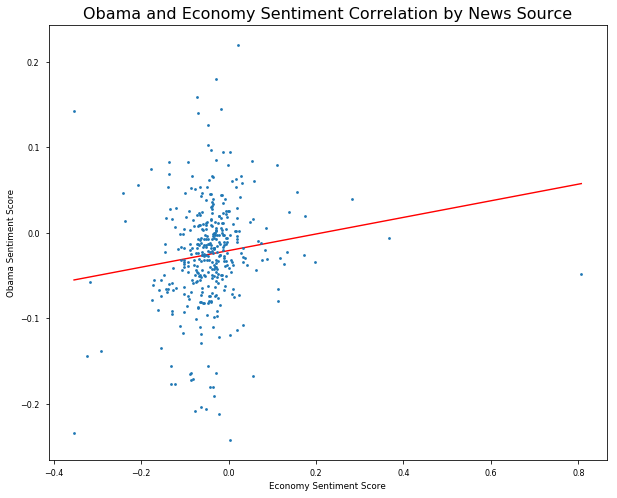

In [63]:
economy = obama_economy['economy'].values
obama = obama_economy['obama'].values

quad = np.polyfit(economy, obama,deg=1)

x = np.linspace(min(economy),max(economy),20)
y = np.polyval(quad,x)

plt.figure(figsize=(10,8))
plt.plot(x,y,color='red')
plt.plot(economy,obama,marker='.',linestyle='none')
plt.xlabel('Economy Sentiment Score')
plt.ylabel('Obama Sentiment Score')
plt.title('Obama and Economy Sentiment Correlation by News Source',fontsize=16)
plt.show()

### Very weak positive relationship among News Sources between economy and Obama sentimentality scores

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000010DCB3D68>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000133957F98>], dtype=object)

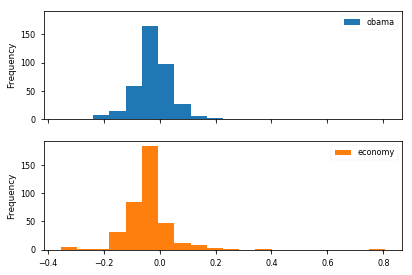

In [64]:
obama_economy.loc[:,['obama','economy']].plot(subplots=True,kind='hist',sharex=True,sharey=True,bins=20)

### Time Series Analyses ###

#### Part One: Overall News Popularity by Platform ####

In [65]:
news_timeline = news_final.set_index('PublishDate')

In [66]:
news_timeline.index = pd.DatetimeIndex(news_timeline.index)

In [67]:
news_timeline.IDLink = news_timeline.IDLink.astype('int').astype('object')

In [68]:
news_timeline = news_timeline.loc['2015':,:]

In [69]:
news_timeline = news_timeline.resample('D').mean()

In [70]:
all_trends = []

for c in ['Facebook','GooglePlus','LinkedIn','SentimentMax']:
    news_timeline['{}Normalized'.format(c)] = news_timeline[c].div(news_timeline.loc['2015-11-12',c]).sub(1).mul(100)
    news_timeline['{}WeeklyTrend'.format(c)] = news_timeline['{}Normalized'.format(c)].rolling(7).mean()
    all_trends.append('{}WeeklyTrend'.format(c))

news_timeline_trimmed = news_timeline.loc['2015-11-12':,all_trends]

In [84]:
news_timeline_trimmed.head(10)

,FacebookWeeklyTrend,GooglePlusWeeklyTrend,LinkedInWeeklyTrend,SentimentMaxWeeklyTrend
PublishDate,,,,
2015-11-12,-42.855529,-51.319068,-12.220074,-9.135660
2015-11-13,-34.895734,-41.905778,2.171768,2.616739
2015-11-14,-33.864374,-36.167133,6.851687,5.437769
2015-11-15,-22.349214,-14.407777,13.255907,26.996390
2015-11-16,-27.745400,-9.893388,11.496451,32.017940
2015-11-17,-30.222522,-10.642374,18.722953,24.972757
2015-11-18,24.655409,-4.327564,8.663460,19.492047
2015-11-19,90.302013,2.542119,11.813220,18.539050
2015-11-20,159.551522,14.260699,7.463276,12.124510


In [72]:
news_platforms = ['FacebookWeeklyTrend','GooglePlusWeeklyTrend','LinkedInWeeklyTrend']

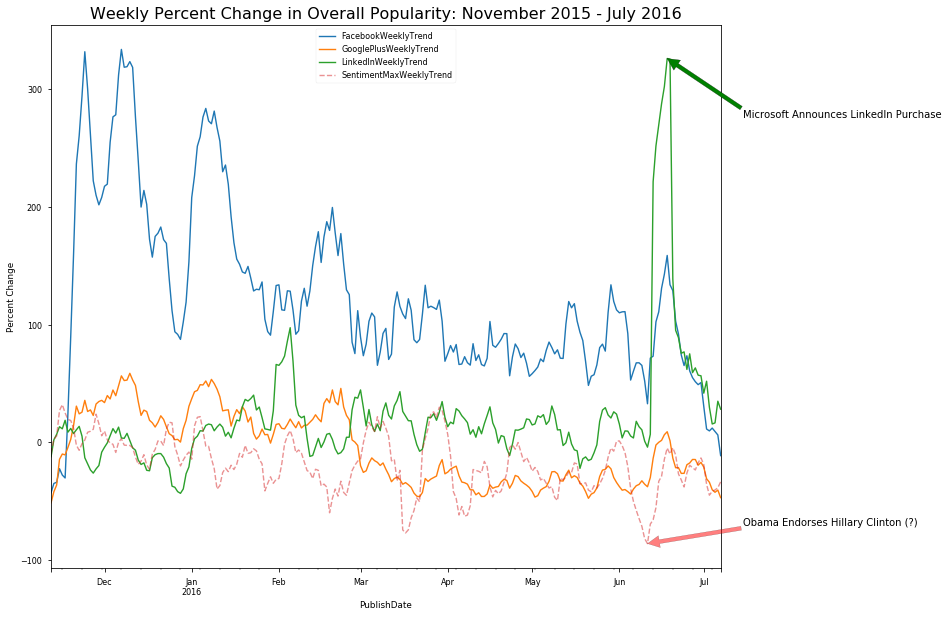

In [93]:
fig = plt.figure()

fig.set_figheight(10)
fig.set_figwidth(12)
_ = news_timeline_trimmed[news_platforms].plot(figsize=(12,10))

_ = plt.annotate('Microsoft Announces LinkedIn Purchase',
                xy=('2016-06-18',news_timeline_trimmed['LinkedInWeeklyTrend'].max()),
             xytext=('2016-07-15',news_timeline_trimmed['LinkedInWeeklyTrend'].max()-50), 
            arrowprops={'facecolor':'green'})

_ = plt.annotate('Obama Endorses Hillary Clinton (?)',
                 xy=('2016-06-11',news_timeline_trimmed['SentimentMaxWeeklyTrend'].min()),
                 xytext=('2016-07-15',news_timeline_trimmed['SentimentMaxWeeklyTrend'].min()+15),
                arrowprops={'facecolor':'red','alpha':.5})

_ = news_timeline_trimmed['SentimentMaxWeeklyTrend'].plot(linestyle='--',alpha=.5,legend=True)

_ = plt.ylabel('Percent Change')
_ = plt.title('Weekly Percent Change in Overall Popularity: November 2015 - July 2016',fontsize=16)
_ = plt.legend(loc='upper center')


plt.show()